In [1]:
import os
import numpy as np
from PIL import Image

import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

In [2]:
torch.manual_seed(111)

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

In [4]:
device = torch.device("cpu")

In [5]:
size = (56,56,3)
pixels = size[0]*size[1]*size[2]
pixels

9408

In [6]:
train_data_length = 4096
train_data = torch.from_numpy(np.zeros((train_data_length, size[0], size[1], size[2])))
dir_ = 'img_align_celeba'

for i, image_name in enumerate(os.listdir(dir_)[:train_data_length]):
    image = Image.open(dir_+'/'+image_name)
    train_data[i] = torch.from_numpy(np.array(image.resize((size[0], size[1])))/256)
    
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

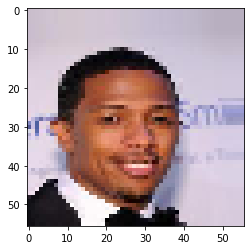

In [7]:
plt.imshow((train_data[33]*256).int())

In [8]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(pixels, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
         )
 
    def forward(self, x):
        x = x.view(x.size(0), pixels)
        output = self.model(x)
        return output

In [10]:
discriminator = Discriminator().to(device=device)

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, pixels),
            nn.Sigmoid(),
      )
    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), size[0], size[1], size[2])
        return output

In [12]:
generator = Generator().to(device=device)

In [13]:
lr = 0.001
num_epochs = 50
loss_function = nn.BCELoss()

In [14]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [15]:
loss_G = []
loss_D = []

In [16]:
for epoch in range(num_epochs):
    for n, (real_samples, useless_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.rand((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples.float())
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()
        
        # Data for training the generator
        latent_space_samples = torch.rand((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            loss_D.append(loss_discriminator)
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")
            loss_G.append(loss_generator)

Epoch: 0 Loss D.: 0.9926398396492004
Epoch: 0 Loss G.: 0.9322584867477417
Epoch: 1 Loss D.: 0.1456538289785385
Epoch: 1 Loss G.: 6.197327136993408
Epoch: 2 Loss D.: 0.3966393768787384
Epoch: 2 Loss G.: 1.2766454219818115
Epoch: 3 Loss D.: 0.0957372710108757
Epoch: 3 Loss G.: 8.28142261505127
Epoch: 4 Loss D.: 0.6578484177589417
Epoch: 4 Loss G.: 0.7185588479042053
Epoch: 5 Loss D.: 0.8361794352531433
Epoch: 5 Loss G.: 0.7432605624198914
Epoch: 6 Loss D.: 0.6356526017189026
Epoch: 6 Loss G.: 0.7648487091064453
Epoch: 7 Loss D.: 0.6067162156105042
Epoch: 7 Loss G.: 1.9243614673614502
Epoch: 8 Loss D.: 0.6864906549453735
Epoch: 8 Loss G.: 0.71296626329422
Epoch: 9 Loss D.: 0.6883190870285034
Epoch: 9 Loss G.: 0.6521472334861755
Epoch: 10 Loss D.: 0.6925132274627686
Epoch: 10 Loss G.: 0.6867413520812988
Epoch: 11 Loss D.: 0.6927033066749573
Epoch: 11 Loss G.: 0.6746410131454468
Epoch: 12 Loss D.: 0.6933525204658508
Epoch: 12 Loss G.: 0.6833634376525879
Epoch: 13 Loss D.: 0.6719006896018982

In [24]:
discriminator(generated_samples.float())

tensor([[0.4997],
        [0.4976],
        [0.4996],
        [0.4961],
        [0.5032],
        [0.4987],
        [0.5026],
        [0.4955],
        [0.5021],
        [0.5011],
        [0.4988],
        [0.5010],
        [0.4991],
        [0.5024],
        [0.4955],
        [0.4952],
        [0.4990],
        [0.5035],
        [0.5005],
        [0.5006],
        [0.4978],
        [0.5022],
        [0.4978],
        [0.5009],
        [0.5008],
        [0.5010],
        [0.4992],
        [0.4986],
        [0.5006],
        [0.5013],
        [0.4990],
        [0.4985]], grad_fn=<SigmoidBackward>)

In [18]:
discriminator(real_samples.float())

tensor([[0.4997],
        [0.5011],
        [0.5026],
        [0.4994],
        [0.4994],
        [0.5026],
        [0.5011],
        [0.4997],
        [0.4949],
        [0.5001],
        [0.5012],
        [0.4975],
        [0.4980],
        [0.4966],
        [0.5026],
        [0.4958],
        [0.4988],
        [0.5009],
        [0.4992],
        [0.4982],
        [0.4969],
        [0.4995],
        [0.5030],
        [0.4990],
        [0.4990],
        [0.5005],
        [0.4991],
        [0.5010],
        [0.5011],
        [0.5024],
        [0.4958],
        [0.4997]], grad_fn=<SigmoidBackward>)

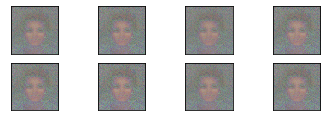

In [25]:
generated_samples = generated_samples.cpu().detach()
for i in range(8):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow((generated_samples[i]*256).int())
    plt.xticks([])
    plt.yticks([])

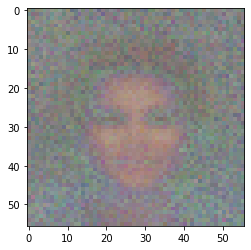

In [26]:
plt.imshow((generated_samples[30]*256).int())